In this project, we are going to examine synthetic credit card transactions and train a model to accurately predict whether a given transaction is fraudulent.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import sqlite3

In [2]:
train_data = pd.read_csv('fraudTrain.csv')

In [3]:
train_data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [4]:
train_data.groupby(['is_fraud']).size()

is_fraud
0    1289169
1       7506
dtype: int64

This is a highly imbalanced dataset, with non-fraud data being more than 180 times of the fraud ones. On the other hand, reducing false negative rate is very important due to the business context. We will need to address it.

First of all, let's quickly build a logistic regression model and see where we can go after that.

In [5]:
train_data.drop(columns = ['Unnamed: 0', 'trans_date_trans_time', 'cc_num',
       'first', 'last', 'street', 'city', 'state', 'dob',
       'trans_num'],inplace = True)

In [6]:
train_data.columns

Index(['merchant', 'category', 'amt', 'gender', 'zip', 'lat', 'long',
       'city_pop', 'job', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

We will convert the categorical variables with one-hot encodings. There will be a huge amount of variables, but let's not worry about that for now.

In [7]:
def one_hot_convert(df, columns):
    
    for Col in columns:
        df = pd.concat([df, pd.get_dummies(train_data[Col], prefix = Col)], axis = 1)
    
    df.drop(columns = columns, inplace = True)
    
    return df

In [8]:
Cat_columns = ['merchant', 'category', 'gender','job']

train_data = one_hot_convert(train_data, Cat_columns)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix

The dataset is too big (1.16M-by-1211, resulting in 10.5GiB) to train if we use one-hot encoding without any restraint. There are several ways to solve it. We can decrease the precision, or we can choose fewer samples to begin with.

I should also create a new column calculating the distance between the cardholder's address and the merchant's.


In [10]:
df_Fraud = train_data[train_data['is_fraud'] == 1]
df_Non_fraud = train_data[train_data['is_fraud'] == 0]

In [12]:
n = df_Fraud.shape[0]

df_Non_fraud = df_Non_fraud.sample(n=n)

df_Non_fraud.shape

df_rest = train_data[train_data['is_fraud'] == 0].drop(df_Non_fraud.index)

df_rest.shape

(1281663, 1212)

In [11]:
little_dataset = pd.concat([df_Fraud,df_Non_fraud], axis = 0)
little_dataset = little_dataset.sample(frac = 1)
little_dataset.shape

(15012, 1212)

In [72]:
X = little_dataset.copy()
Y = little_dataset['is_fraud']
X.drop(columns = ['is_fraud'], inplace = True)

scaler = StandardScaler()
scaler.fit(X)

X = scaler.transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
LR = LogisticRegression(max_iter = 1000)

LR.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [73]:
LR.score(X_test, y_test)

0.8275632490013316

In [46]:
y_pred = LR.predict(X_test)

confusion_matrix(y_pred,y_test)

array([[675, 157],
       [107, 563]], dtype=int64)

In [47]:
LR.score(X_train,y_train)

0.8729089563286454

Using logistic regression, the fitted model predicts horribly, even for the training set. The confusion matrix shows that most predictions are flagged as non-fraud. It suggests that it is hard to describe the final prediction with linear hyperplanes.

In [74]:
little_dataset['distance'] = np.sqrt(np.power(little_dataset['lat']- little_dataset['merch_lat'],2) + np.power(little_dataset['long']- little_dataset['merch_long'],2) )
little_dataset = little_dataset.sample(frac= 1)

In [12]:
X = little_dataset.copy()
Y = little_dataset['is_fraud']
X.drop(columns = ['is_fraud'], inplace = True)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
LR = LogisticRegression()

LR.fit(X_train,y_train)
LR.score(X_test, y_test)

0.4986684420772304

In [50]:
y_pred = LR.predict(X_test)

confusion_matrix(y_pred,y_test)

array([[736, 766],
       [  0,   0]], dtype=int64)

In [13]:
scaler = StandardScaler()
scaler.fit(X)

X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
LR = LogisticRegression(max_iter =500)

LR.fit(X_train,y_train)
LR.score(X_test, y_test)

0.8215712383488681

In [105]:
y_pred = LR.predict(X_test)

confusion_matrix(y_test, y_pred)

array([[619, 127],
       [141, 615]], dtype=int64)

I tried to use SVM to fit the data, but the process just takes too long. According to the documentation, it scales at least quadratically with respect to the number of samples and is impractical beyond tens of thousands of them. Our little dataset is right on the cusp, so I can see why things are not great here. Instead, we can either use the linear SVM or other models.

```python
svm = SVC()
svm.fit(X_train,y_train)
svm.score(X_test, y_test)
```

Let's first try to visualize our dataset a little bit. We can plot out the scatter plot of (amount, distance from cardholder address) and see if there are some relations we can exploit.

In [80]:
scatter_df = little_dataset[['amt','distance','is_fraud']]

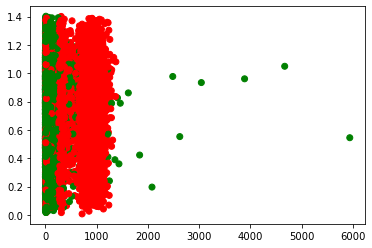

In [82]:
colors = ['red' if tag == 1 else 'green' for tag in scatter_df['is_fraud']]

plt.scatter(scatter_df['amt'], scatter_df['distance'], c = colors)

It looks like it is hard to make out whether the transaction is fraudulent from the distance. Interestingly, the very high transaction amount correlates to genuine transactions.

In [15]:
job_col = [col for col in little_dataset.columns if 'job' in col]
job_col[:5]

['job_Academic librarian',
 'job_Accountant, chartered',
 'job_Accountant, chartered certified',
 'job_Accountant, chartered public finance',
 'job_Accounting technician']

In [30]:
new_train_data = pd.read_csv('fraudTrain.csv')

job_analysis = new_train_data[['job','is_fraud']]

job_analysis.head()

,job,is_fraud
0,"Psychologist, counselling",0
1,Special educational needs teacher,0
2,Nature conservation officer,0
3,Patent attorney,0
4,Dance movement psychotherapist,0


In [20]:
job_df = job_analysis.groupby(['job']).mean()

In [27]:
trimmed_job_df = job_df[job_analysis.groupby(['job']).count()>50]

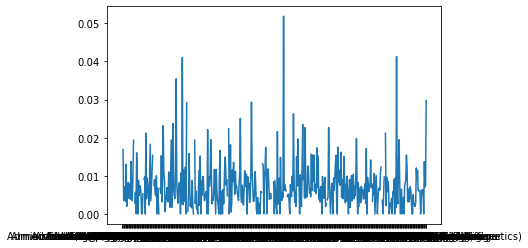

In [28]:
plt.plot(trimmed_job_df)

Here, we write a function to observe the influence of one single categorical variable on determining whether the transaction is fraudulent.

In [31]:
def check_category_correlation(df, col, threshold = None):
    col_df = df[[col,'is_fraud']]
    col_analysis = col_df.groupby([col]).mean()
    if threshold and type(threshold) == int:
        col_analysis = col_analysis[col_df.groupby([col]).count() > threshold]
    plt.plot(col_analysis)

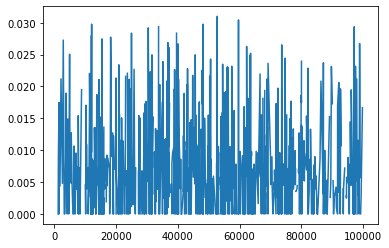

In [37]:
check_category_correlation(new_train_data, 'zip', threshold = 50)

In [38]:
from sklearn.metrics import roc_curve

We compute the ROC curve for logistic regression. By default, it plots the false positive rate against the true positive rate. Perhaps we should plot the true negative and false negative rate.

In [49]:
y_proba = LR.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_proba[:,1])

<class 'numpy.ndarray'>


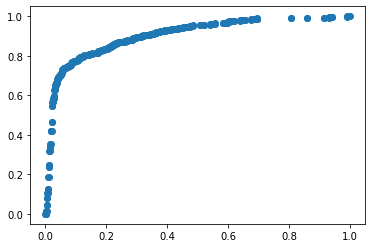

In [68]:
plt.scatter(fpr, tpr)

In [73]:
tnr, fnr = 1-fpr, 1-tpr

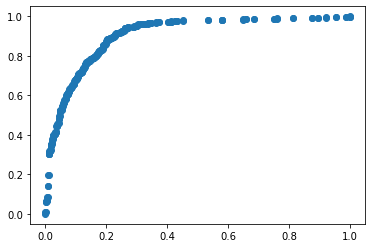

In [78]:
plt.scatter(fnr, tnr)

#plt.plot([0,0], [1,1], 'k-', color = 'r')

For what we care about (low false negative rate), logistic regression is not that good, as it climbs relatively slowly in the beginning.

In [81]:
feature_col = list(little_dataset.columns)
feature_col.remove('is_fraud')

rankings_LR = sorted(zip(feature_col, LR.coef_.reshape(1211)),key= lambda x: abs(x[1]), reverse = True)

In [82]:
rankings_LR[:10]

[('amt', 4.910995034291404),
 ('category_shopping_net', -1.2528353122880749),
 ('merchant_fraud_Ritchie, Bradtke and Stiedemann', -1.2163465376722709),
 ('category_personal_care', 0.783347681555894),
 ('category_shopping_pos', -0.5014025096429848),
 ('job_Museum education officer', 0.49313328426450187),
 ('category_gas_transport', 0.422631911765152),
 ('category_misc_pos', 0.41732220549958726),
 ('job_Surveyor, rural practice', -0.4039316535273326),
 ('job_Water engineer', -0.3623022884909591)]

In [145]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
DTC = DecisionTreeClassifier(max_depth = 20)

DTC.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=20)

In [138]:
DTC.score(X_test,y_test)

0.9640479360852197

In [136]:
y_pred_DTC = DTC.predict(X_test)

confusion_matrix(y_test,y_pred_DTC)

array([[713,  33],
       [ 26, 730]], dtype=int64)

In [115]:
def random_testing(df, frac, model):
    smaller = df.sample(frac = frac)
    smaller_X = smaller.drop(columns = ['is_fraud'])
    smaller_Y = smaller[['is_fraud']]
    smaller_X_transformed = scaler.transform(smaller_X)
    
    print(model.score(smaller_X_transformed, smaller_Y))
    
    Y_predict = model.predict(smaller_X_transformed)
    
    print(confusion_matrix(smaller_Y, Y_predict))
    
    
    y_proba = model.predict_proba(smaller_X_transformed)
    
    fpr, tpr, thresholds = roc_curve(smaller_Y, y_proba[:,1])
    
    plt.scatter(1-tpr, 1-fpr)
    


0.8414489311163895
[[108464  20449]
 [   110    645]]


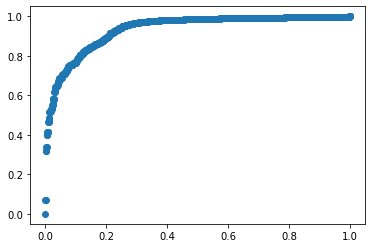

In [130]:
random_testing(train_data, 0.1, LR)

0.9506663170558658
[[122581   6397]
 [     0    690]]


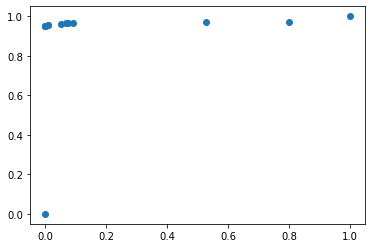

In [140]:
random_testing(train_data, 0.1, DTC)

From the confusion matrix above, we can see that when the dataset is imbalanced, the false negative rate is fine, but the number of flagged transactions are perhaps a bit high. Can we do a pipeline to re-evaluate those flagged transactions?

Also, it is possible that the very low false negative rate happens because we have already trained on most of the fraud data. Perhaps we should re-consider our random testing method. I have extracted the df_rest from the remaining non-fraud data. We should iteratively test all data and use the confusion matrix to sum up all the results. All the fraud entries are already in the test set, so we should utilize that.

In [148]:
rankings_DTC = sorted(zip(feature_col, DTC.feature_importances_.reshape(1211)),key= lambda x: abs(x[1]), reverse = True)

rankings_DTC[:10]

[('amt', 0.7324315644664732),
 ('category_gas_transport', 0.08057419546461565),
 ('category_grocery_net', 0.02375913780783269),
 ('category_travel', 0.015594658164946066),
 ('category_home', 0.014784477717247347),
 ('category_food_dining', 0.014418878834217535),
 ('category_misc_pos', 0.013018883694656631),
 ('city_pop', 0.010497054440302642),
 ('unix_time', 0.009884335727756141),
 ('category_shopping_net', 0.008190842344716434)]

[Text(261.26518250857424, 212.26285714285714, 'X[0] <= -0.166\ngini = 0.5\nsamples = 13510\nvalue = [6760, 6750]'),
 Text(206.384474522293, 201.90857142857143, 'X[0] <= -0.734\ngini = 0.322\nsamples = 8252\nvalue = [6585, 1667]'),
 Text(146.3519720725135, 191.5542857142857, 'X[703] <= 1.412\ngini = 0.461\nsamples = 3883\nvalue = [2485, 1398]'),
 Text(145.03967417932387, 181.2, 'X[0] <= -0.755\ngini = 0.378\nsamples = 3326\nvalue = [2485, 841]'),
 Text(101.3750122488976, 170.84571428571428, 'X[704] <= 2.939\ngini = 0.263\nsamples = 2571\nvalue = [2171, 400]'),
 Text(81.362469377756, 160.49142857142857, 'X[710] <= 2.126\ngini = 0.209\nsamples = 2458\nvalue = [2167, 291]'),
 Text(51.835766780989715, 150.13714285714286, 'X[714] <= 3.292\ngini = 0.137\nsamples = 2089\nvalue = [1934, 155]'),
 Text(23.621362077413032, 139.78285714285715, 'X[708] <= 1.851\ngini = 0.054\nsamples = 1831\nvalue = [1780, 51]'),
 Text(15.419500244977952, 129.42857142857144, 'X[1149] <= 11.758\ngini = 0.011\nsamples

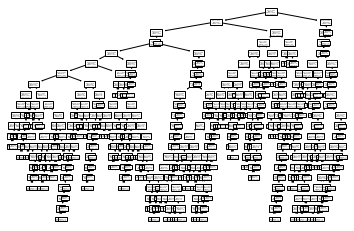

In [146]:
tree.plot_tree(DTC)